# Replication Jorda 2005

Installation des packages

In [1]:
install.packages("vars")
install.packages("lpirfs")
install.packages("reshape2")
install.packages("ggplot2")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Introduction

Jorda (2005, Estimation and Inference of Impulse Responses by Local Projection,  **The American Economic Review**, vol 95(1), pp 161-182.) propose la méthode des projections locales pour calculer les fonctions d'impulsion-réponse.


Il illustre sa méthode en revenant sur une question de politique monétaire. L'article de Taylor (1993, Discretion versus Policy Rules. **Carnegie-Rochester Conference Series on Public Policy, 39(0), pp. 195-214) a suscité beaucoup de travaux de recherches sur les règles de taux d'intérêt pour la conduite de la politique monétaire. Ces règles décrivent comment le taux d'intérêt devrait varier en fonction de l'output gap et du taux d'inflation. Le niveau du taux d'intérêt dépend d'un arbitrage entre les niveaux d'activités économiques et le niveau de l'inflation. Pour évaluer l'efficacité et l'optimalité des règles de taux d'intérêt dans le cadre de la politique monétaire, Jord\`{a} étudie la dynamique des relations entre :


1.    l'output gap $y_{t}$ mesuré par la différence en pourcentage entre le PIB réel et le PIB potentiel (source the Congressional Budget Office)
2.    le taux d'inflation $\pi_{t}$ mesuré par le déflateur du PIB en pourcentage annualisé
3.    le taux d'intérêt $i_{t}$ mesuré par le taux des fonds fédéraux (federal fund rates) en pourcentage annualisé


Jorda dispose de données trimestrielles de 1955-T1 à 2003-I. Ces données sont contenues dans le dataframe interest\_rules\_var\_data du package liprfs de R.

## Importation des librairies vars et local projection

In [14]:
library(vars)
library(lpirfs)

## Importation des données dans le dataframe endog_data

In [15]:
endog_data <- interest_rules_var_data
str(endog_data)

tibble [193 × 3] (S3: tbl_df/tbl/data.frame)
 $ GDP_gap: num [1:193] 2.62 3.47 4.05 3.8 2.54 ...
 $ Infl   : num [1:193] 1.6 2.26 2.89 2.7 3.96 ...
 $ FF     : num [1:193] 1.34 1.5 1.94 2.36 2.48 ...


## Fonction impulsion réponse basées sur l'estimation d'un modèle VAR



### Sélection du nombre de retards optimal



On determine le nombre de retards du VAR en choisissant un nombre de retards maximum égal à 8 et en introduisant une constante dans le modèle VAR.

In [17]:
pselect<-VARselect(y=endog_data,lag.max=8,type=c("const"))

# Affichage des critères de sélection
# pselect$criteria
# nombre de retards optimal selon les critères de sélection
pselect$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     6      3      2      6

### Estimation d'un modèle VAR



On estime un VAR avec deux retards et une constante

In [18]:
var.2lag <-VAR(y = endog_data,type="const",lag.max = 2)
summary(var.2lag)


VAR Estimation Results:
Endogenous variables: GDP_gap, Infl, FF 
Deterministic variables: const 
Sample size: 191 
Log Likelihood: -736.927 
Roots of the characteristic polynomial:
0.9366 0.9366 0.6731 0.5747 0.2547 0.08768
Call:
VAR(y = endog_data, type = "const", lag.max = 2)


Estimation results for equation GDP_gap: 
GDP_gap = GDP_gap.l1 + Infl.l1 + FF.l1 + GDP_gap.l2 + Infl.l2 + FF.l2 + const 

           Estimate Std. Error t value Pr(>|t|)    
GDP_gap.l1  1.13243    0.07472  15.156  < 2e-16 ***
Infl.l1     0.09217    0.05585   1.650 0.100592    
FF.l1       0.04352    0.06825   0.638 0.524489    
GDP_gap.l2 -0.25374    0.07115  -3.566 0.000462 ***
Infl.l2    -0.10386    0.05597  -1.856 0.065113 .  
FF.l2      -0.11743    0.06928  -1.695 0.091775 .  
const       0.44342    0.13042   3.400 0.000827 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.8091 on 184 degrees of freedom
Multiple R-Squared: 0.9044,	Adjusted R-squared: 0.901

### Estimation des functions impulse-response



Les chocs structurels sont déterminés par la méthode de Cholesky avec l'ordre $(y_{t}, \pi_{t}, i_{t})'$. Jorda suppose que :

*   un choc sur l'output gap à un effet instantané sur les le taux d'inflation et le taux d'intérêt,
*   un choc sur le taux d'intérêt n'a pas d'effet instantané sur l'output gap et le taux d'inflation.

L'ordre des variables dans le dataframe correspond bien à celui choisi pour la décomposition de Cholesky.

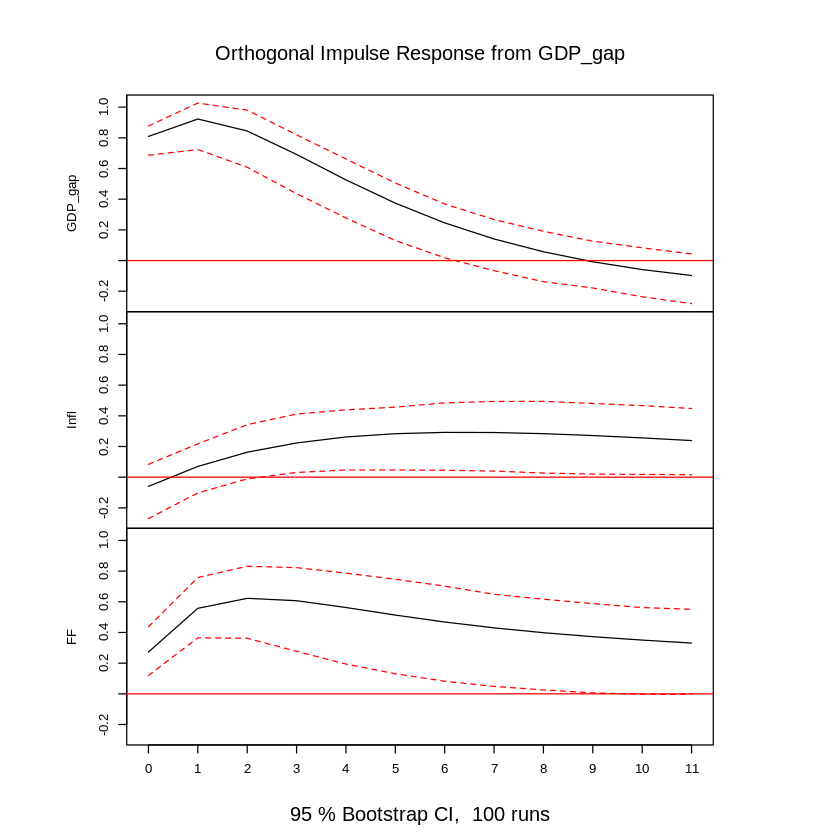

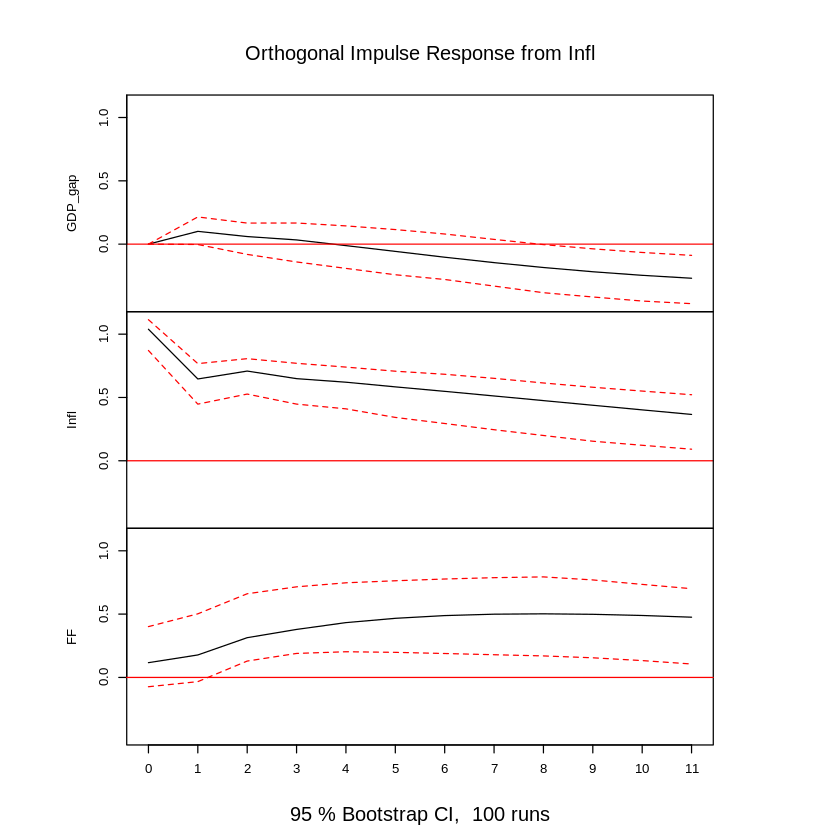

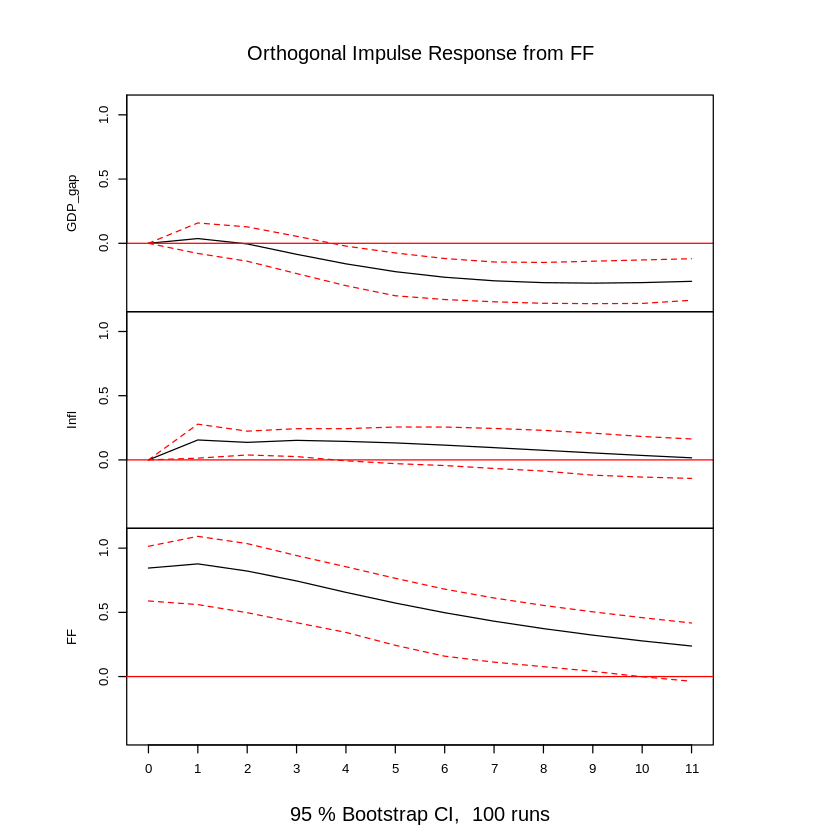

In [19]:
irf_VAR<-irf(var.2lag,n.ahead = 11,ortho = TRUE,ci=0.95)
plot(irf_VAR)

Dans son article, Jorda parle de "**price puzzle**" pour designer le fait que dans la littérature sur les modèles VAR, on obtient souvent le résultat contre-intuitif que l'inflation augmente suite à un choc sur les taux d'intérêt.

#### Estimation des fonctions impulsion réponse par la méthodes des projection locales

##### Spécification 1 : nombre de retards fixe



Jorda estime les projections locales avec un nombre de retards égal à 4 pour toutes horizons et toutes les variables. Chaque choc est l'égal à l'écart type du choc structurel correspondant.

In [20]:
irf_LP_4l <-lp_lin(endog_data = endog_data,
                     lags_endog_lin = 4,
                     trend = 0,
                     shock_type = 0,
                     confint=1.96,
                     hor=11)

Les fonctions impulsion réponse figurent ci-dessous

[[1]]
NULL


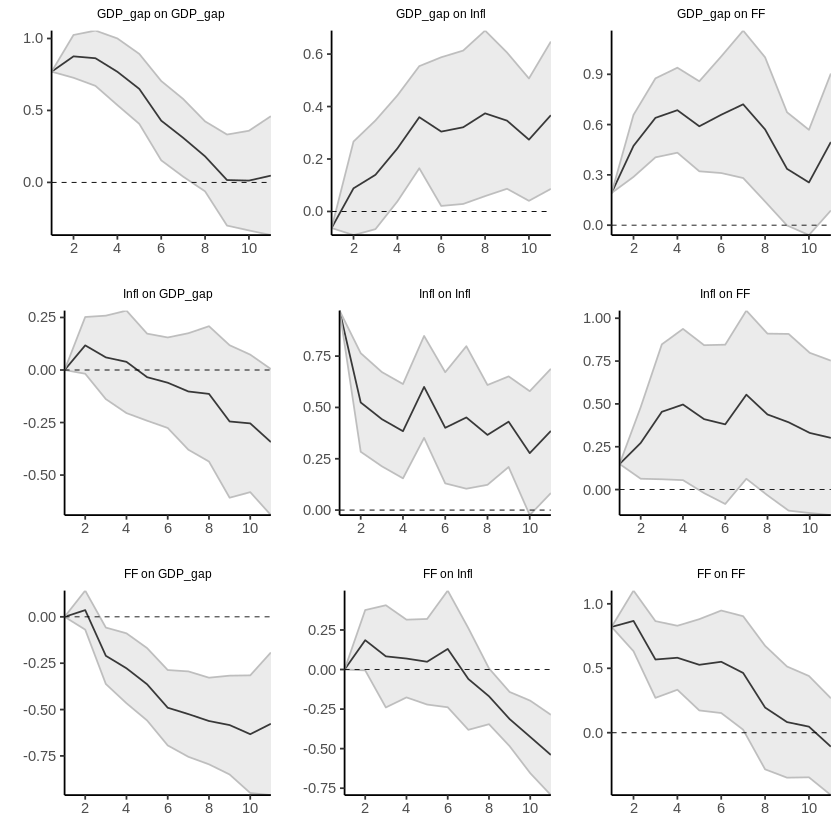

In [21]:
plot(irf_LP_4l)

##### Spécification 2 : Nombre de retards endogène



Le nombre de retards pour les régressions des projections locales peut varier suivant les horizons et les variables. On considère un nombre de retards maximal égal à 8. Le nombre de retards optimal minimise le critère BIC

[[1]]
NULL


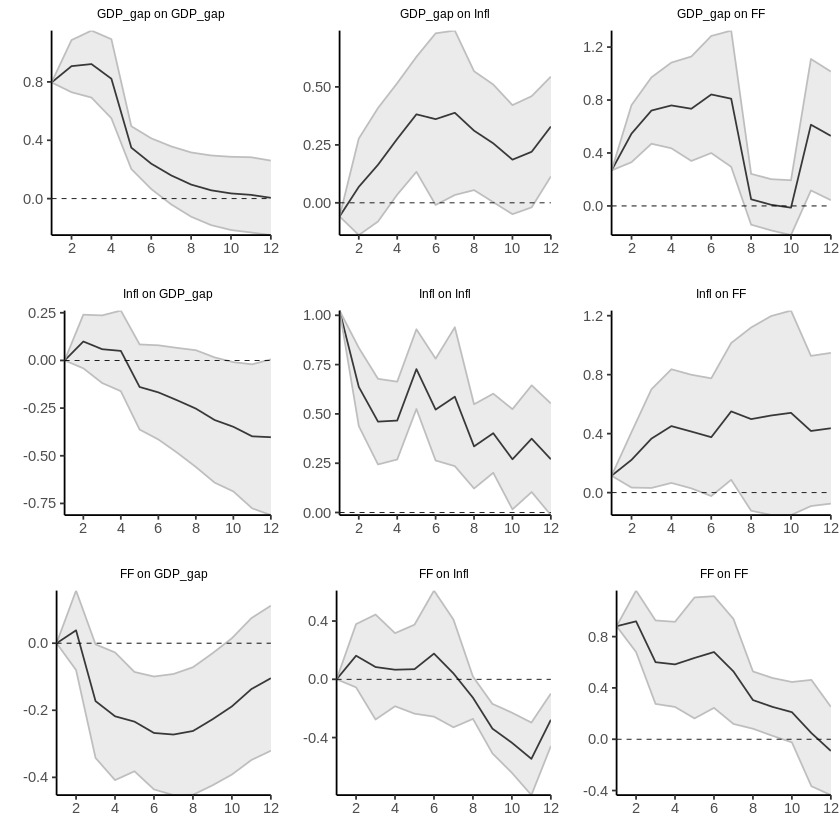

In [9]:
irf_LP <-lp_lin(endog_data = endog_data,
                    lags_endog_lin = NaN,
                    lags_criterion = 'BIC',
                    max_lags = 8,
                    trend = 0,
                    shock_type = 0,
                    confint=1.96,
                    hor=12)

plot(irf_LP)

In [10]:
# Affichage des irf
irf_LP_4l$irf_lin_mean

, , 1

            [,1]       [,2]      [,3]      [,4]      [,5]      [,6]      [,7]
[1,]  0.76921540 0.87582397 0.8628188 0.7686700 0.6495739 0.4289096 0.3097732
[2,] -0.06310773 0.08824105 0.1397125 0.2402117 0.3593400 0.3044605 0.3209420
[3,]  0.19204448 0.47295175 0.6402030 0.6857967 0.5898251 0.6586954 0.7209147
          [,8]      [,9]      [,10]     [,11]      [,12]
[1,] 0.1807608 0.0162575 0.01254278 0.0469958 0.07235766
[2,] 0.3740189 0.3462197 0.27375774 0.3669900 0.41974880
[3,] 0.5711392 0.3358602 0.25472205 0.4961299 0.42565203

, , 2

          [,1]      [,2]       [,3]       [,4]        [,5]        [,6]
[1,] 0.0000000 0.1172453 0.06002656 0.03880626 -0.03414115 -0.06053067
[2,] 0.9717678 0.5241793 0.44285746 0.38430289  0.59992238  0.40077850
[3,] 0.1492738 0.2721807 0.45388470 0.49636625  0.41090816  0.38066698
           [,7]       [,8]       [,9]      [,10]      [,11]      [,12]
[1,] -0.1021679 -0.1136479 -0.2449473 -0.2540358 -0.3429438 -0.2549663
[2,]  0.4511925  0.3661737  0.4305682  0.2773378  0.3855464  0.2711084
[3,]  0.5537716  0.4382506  0.3926947  0.3305545  0.3016951  0.3080193

, , 3

          [,1]       [,2]        [,3]        [,4]        [,5]       [,6]
[1,] 0.0000000 0.03620789 -0.21012020 -0.27748580 -0.36383230 -0.4901935
[2,] 0.0000000 0.18520321  0.08319524  0.06937324  0.04907495  0.1300588
[3,] 0.8209259 0.86758807  0.56815947  0.58177362  0.52702795  0.5504509
            [,7]       [,8]        [,9]       [,10]      [,11]      [,12]
[1,] -0.52451372 -0.5618380 -0.58369060 -0.63284075 -0.5767245 -0.4710262
[2,] -0.05992412 -0.1691973 -0.31309446 -0.42602508 -0.5398719 -0.3618341
[3,]  0.46365199  0.1953165  0.08246098  0.04707795 -0.1082591 -0.2616423

##### Comparaison graphique : Effet d'un choc sur le taux d'intéret



On peut comparer les impulsions-réponses obtenues par les deux méthodes. On regarde les impulsions-réponses dans le cas d'un choc sur les taux d'intérêt qui présentent des différences selon la méthode d'estimation. On ne reporte pas les intervalles de confiance ce qui limite la portée des conclusions cependant.

*   irf_LP_4l\$irf_lin_mean contient les IRF estimées à partir de la méthode de projection locate avec 4 retards.
*   irf_lin_mean[1,,3] contient les IRF d'un choc sur le taux d'intérêt sur l'output gap

*   irf_VAR\$irfFF contient les IRF suite à un choc sur le taux d'intérêt
*   irf_VAR\$irfFF[,1] contient les IRF de l'output gap suite à un choc sur le taux d'intérêt

Warning message:
“Continuous limits supplied to discrete scale.
ℹ Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


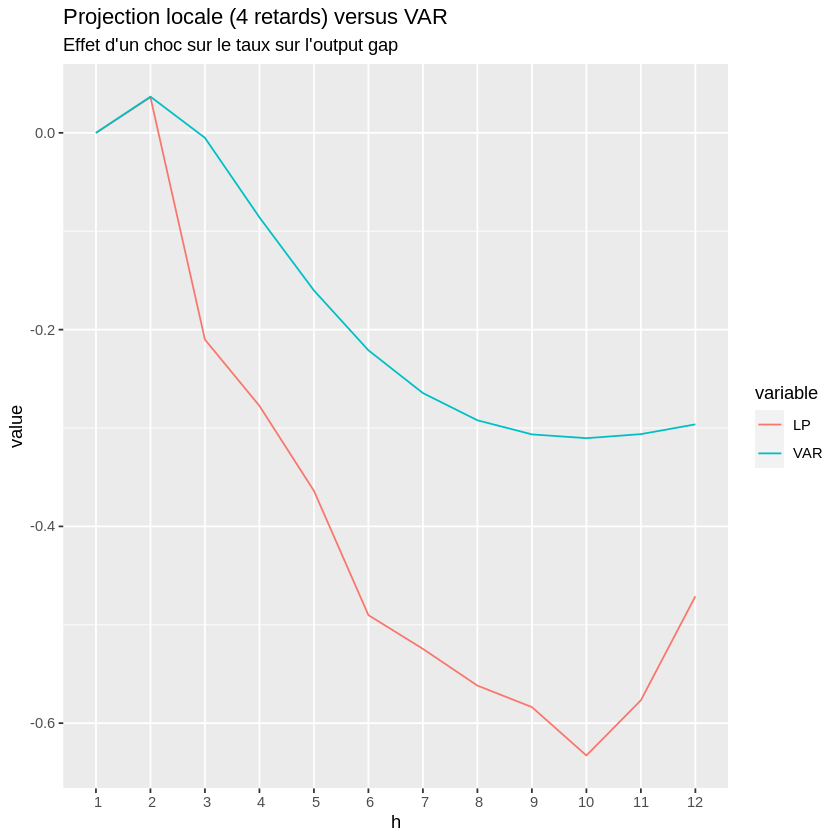

In [11]:
library(reshape2)
library(ggplot2)
comp_irf<-data.frame(h=seq(1,12),irf_LP_4l$irf_lin_mean[1,,3],irf_VAR$irf$FF[,1])
colnames(comp_irf)<-c('h','LP','VAR')


df_comp<-melt(comp_irf,id.var='h')
p<-ggplot(df_comp,aes(x=h,y=value,col=variable))+geom_line()+
scale_x_discrete(limits=comp_irf$h)
p+labs(title = "Projection locale (4 retards) versus VAR",subtitle = "Effet d'un choc sur le taux sur l\'output gap")

On voit que l'IRF obtenue avec le modèle VAR a tendance a sous-estimer l'effet d'un choc sur le taux d'intérêt sur le PIB.

Warning message:
“Continuous limits supplied to discrete scale.
ℹ Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


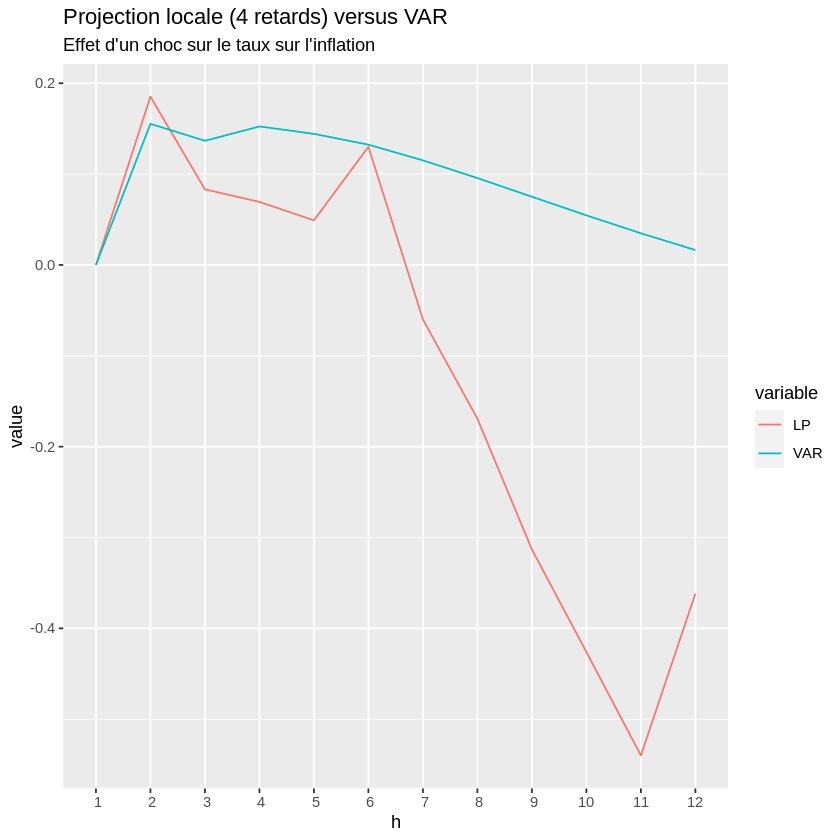

In [12]:
comp_irf<-data.frame(h=seq(1,12),irf_LP_4l$irf_lin_mean[2,,3],irf_VAR$irf$FF[,2])
colnames(comp_irf)<-c('h','LP','VAR')

df_comp<-melt(comp_irf,id.var='h')
p<-ggplot(df_comp,aes(x=h,y=value,col=variable))+geom_line()+
scale_x_discrete(limits=comp_irf$h)
p+labs(title = "Projection locale (4 retards) versus VAR",subtitle = "Effet d'un choc sur le taux sur l'inflation")

On voit que les deux IRF sont très proches jusqu'à h=7. Après cette date, l'IRF obtenue par la projection locale devient négative tandis que celle obtenue par le VAR reste positive. L'IRF par projection locale est plus proche de ce que l'on peut anticiper de l'effet d'une hausse des taux sur l'inflation.

Warning message:
“Continuous limits supplied to discrete scale.
ℹ Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


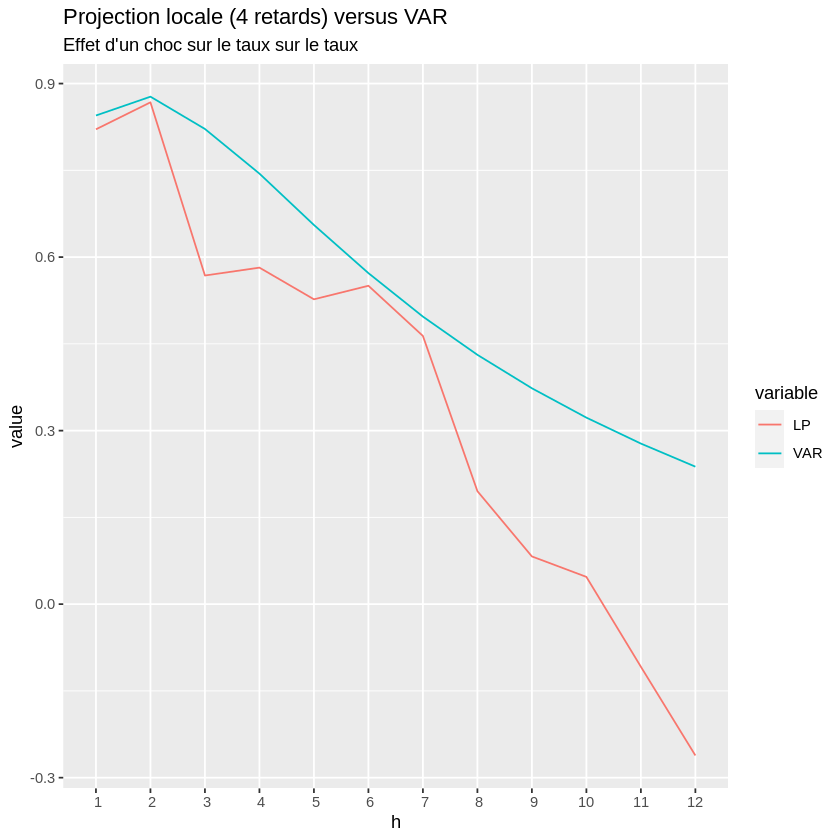

In [13]:
comp_irf<-data.frame(h=seq(1,12),irf_LP_4l$irf_lin_mean[3,,3],irf_VAR$irf$FF[,3])
colnames(comp_irf)<-c('h','LP','VAR')

df_comp<-melt(comp_irf,id.var='h')
p<-ggplot(df_comp,aes(x=h,y=value,col=variable))+geom_line()+
scale_x_discrete(limits=comp_irf$h)
p+labs(title = "Projection locale (4 retards) versus VAR",subtitle = "Effet d'un choc sur le taux sur le taux")